# Optical Flow

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import kornia
from scipy.interpolate import RectBivariateSpline
import glob
from random import sample

/home/calvin/Projects/computer-vision/.venv/lib/python3.11/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


## Helper Functions

In [2]:
def plot_tensor(tensor, colour='gray'):
    np_array = kornia.utils.tensor_to_image(tensor)
    plt.imshow(np_array, cmap=colour)
    plt.show()

def save_tensor(filename, tensor, colour='gray'):
    np_array = kornia.utils.tensor_to_image(tensor)
    plt.imsave(filename, np_array, cmap=colour)

def img_to_tensor(img):
    # img = img[:, :, 0:3]  # take only rgb channels
    img = img.astype('float32') / 255.0  # convert to 0..1 scale
    tensor = kornia.utils.image_to_tensor(img, keepdim=False)
    return tensor

def img_to_gray_tensor(img):
    tensor = img_to_tensor(img)
    return kornia.color.rgb_to_grayscale(tensor)


## Given Code

In [3]:
'''
python by:  youngjung uh, Clova ML, Naver
contact:    youngjung.uh@navercorp.com
date:       17 Dec 2018

-------------------------------------------------------------------
----- below comment came from the original (flowToColor.m) --------
-------------------------------------------------------------------
flowToColor(flow, maxFlow) flowToColor color codes flow field, normalize
based on specified value,

flowToColor(flow) flowToColor color codes flow field, normalize
based on maximum flow present otherwise

According to the c++ source code of Daniel Scharstein
Contact: schar@middlebury.edu

Author: Deqing Sun, Department of Computer Science, Brown University
Contact: dqsun@cs.brown.edu
$Date: 2007-10-31 18:33:30 (Wed, 31 Oct 2006) $

Copyright 2007, Deqing Sun.

                        All Rights Reserved

Permission to use, copy, modify, and distribute this software and its
documentation for any purpose other than its incorporation into a
commercial product is hereby granted without fee, provided that the
above copyright notice appear in all copies and that both that
copyright notice and this permission notice appear in supporting
documentation, and that the name of the author and Brown University not be used in
advertising or publicity pertaining to distribution of the software
without specific, written prior permission.

THE AUTHOR AND BROWN UNIVERSITY DISCLAIM ALL WARRANTIES WITH REGARD TO THIS SOFTWARE,
INCLUDING ALL IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR ANY
PARTICULAR PURPOSE.  IN NO EVENT SHALL THE AUTHOR OR BROWN UNIVERSITY BE LIABLE FOR
ANY SPECIAL, INDIRECT OR CONSEQUENTIAL DAMAGES OR ANY DAMAGES
WHATSOEVER RESULTING FROM LOSS OF USE, DATA OR PROFITS, WHETHER IN AN
ACTION OF CONTRACT, NEGLIGENCE OR OTHER TORTIOUS ACTION, ARISING OUT OF
OR IN CONNECTION WITH THE USE OR PERFORMANCE OF THIS SOFTWARE.
'''

def flowToColor(flow, maxflow=None, verbose=False):
    '''
    args
        flow (numpy array) height x width x 2
    return
        img_color (numpy array) height x width x 3
    '''

    UNKNOWN_FLOW_THRESH = 5e2
    eps = 1e-6

    height, widht, nBands = flow.shape

    if nBands != 2:
        exit('flowToColor: image must have two bands')

    u = flow[:, :, 0]
    v = flow[:, :, 1]

    maxu = -999
    maxv = -999

    minu = 999
    minv = 999
    maxrad = -1

    # fix unknown flow
    idxUnknown = (abs(u) > UNKNOWN_FLOW_THRESH) | (abs(v) > UNKNOWN_FLOW_THRESH)
    u[idxUnknown] = 0
    v[idxUnknown] = 0

    maxu = max(maxu, u.max())
    minu = min(minu, u.min())

    maxv = max(maxv, v.max())
    minv = min(minv, v.min())

    rad = np.sqrt(u ** 2 + v ** 2)
    maxrad = max(maxrad, rad.max())

    if verbose:
        print('max flow: %.4f flow range: u = %.3f .. %.3f; v = %.3f .. %.3f\n' %
              (maxrad, minu, maxu, minv, maxv))

    if maxflow is not None:
        if maxflow > 0:
            maxrad = maxflow

    u = u / (maxrad + eps)
    v = v / (maxrad + eps)

    img = computeColor(u, v)

    # unknown flow
    # IDX = repmat(idxUnknown, [1, 1, 3])
    img[idxUnknown] = 0

    return img

def computeColor(u, v, cast_uint8=True):
    '''
    args
        u (numpy array) height x width
        v (numpy array) height x width
        cast_uint8 (bool) set False to have image range 0-1 (np.float32)
    return
        img_color (numpy array) height x width x 3
    '''

    nanIdx = np.isnan(u) | np.isnan(v)
    u[nanIdx] = 0
    v[nanIdx] = 0

    colorwheel = makeColorwheel()
    ncols = colorwheel.shape[0]

    rad = np.sqrt(u ** 2 + v ** 2)

    a = np.arctan2(-v, -u)/np.pi

    fk = (a + 1) / 2 * (ncols - 1)  # -1~1 maped to 1~ncols

    k0 = np.floor(fk).astype(int)  # 1, 2, ..., ncols

    k1 = k0 + 1
    k1[k1 == ncols + 1] = 1

    f = fk - k0

    height, width = u.shape
    img = np.zeros((height, width, 3), np.float32)
    nrows = colorwheel.shape[1]
    for i in range(nrows):
        tmp = colorwheel[:, i]
        col0 = tmp[k0.reshape(-1)] / 255
        col1 = tmp[k1.reshape(-1)] / 255
        col = col0.reshape(height, width) * (1 - f) + \
              col1.reshape(height, width) * f

        idx = rad <= 1
        col[idx] = 1 - rad[idx] * (1 - col[idx])  # increase saturation with radius

        col[np.logical_not(idx)] *= 0.75  # out of range

        img[:, :, i] = col * (1 - nanIdx)

    if cast_uint8:
        img = np.floor(img * 255).astype(np.uint8)
    return img


def makeColorwheel():
    '''
    color encoding scheme
    adapted from the color circle idea described at
    http://members.shaw.ca/quadibloc/other/colint.htm
    '''

    RY = 15
    YG = 6
    GC = 4
    CB = 11
    BM = 13
    MR = 6

    ncols = RY + YG + GC + CB + BM + MR

    colorwheel = np.zeros((ncols, 3))  # r g b

    col = 0
    # RY
    colorwheel[0:RY, 0] = 255
    colorwheel[0:RY, 1] = np.floor(255*np.array(range(RY))/RY)
    col = col+RY

    # YG
    colorwheel[col:col+YG, 0] = 255 - np.floor(255*np.array(range(YG))/YG)
    colorwheel[col:col+YG, 1] = 255
    col = col+YG

    # GC
    colorwheel[col:col+GC, 1] = 255
    colorwheel[col:col+GC, 2] = np.floor(255*np.array(range(GC))/GC)
    col = col+GC

    # CB
    colorwheel[col:col+CB, 1] = 255 - np.floor(255*np.array(range(CB))/CB)
    colorwheel[col:col+CB, 2] = 255
    col = col+CB

    # BM
    colorwheel[col:col+BM, 2] = 255
    colorwheel[col:col+BM, 0] = np.floor(255*np.array(range(BM))/BM)
    col = col+BM

    # MR
    colorwheel[col:col+MR, 2] = 255 - np.floor(255*np.array(range(MR))/MR)
    colorwheel[col:col+MR, 0] = 255

    return colorwheel


# flowToColor(np.zeros((224,224,2)))

## Part 1. Computing Optical Flow

We want to solve this equation where $I_x$, $I_y$, $I_t$ are the partial derivatives. 
$$
\begin{bmatrix} \sum I_x I_x & \sum I_x I_y \\ \sum I_x I_y & \sum I_y I_y \end{bmatrix}
\begin{bmatrix} u \\ v \end{bmatrix}
=
-
\begin{bmatrix} \sum I_x I_t \\ \sum I_y I_t  \end{bmatrix}
$$
We can use some variables to make this more manageable and easier to reference in the code below. Matrix $M$ is square and has an inverse $M^{-1}$ if $det(M)\ne 0$
$$
M
\begin{bmatrix} u \\ v \end{bmatrix}
=
\begin{bmatrix} a & c \\ c & d \end{bmatrix}
\begin{bmatrix} u \\ v \end{bmatrix}
=
\begin{bmatrix} -p \\ -q  \end{bmatrix}
$$
Assuming $M^{-1}$ exists, its easy to solve for $\begin{bmatrix} u \\ v \end{bmatrix}$ as follows.
$$
\begin{bmatrix} u \\ v \end{bmatrix}
=
M^{-1}
\begin{bmatrix} -p \\ -q  \end{bmatrix}
=
\frac{1}{det(M)}
adj(M)
\begin{bmatrix} -p \\ -q  \end{bmatrix}
=
\frac{1}{ad-c^2}
\begin{bmatrix} d & -c \\ -c & a \end{bmatrix}
\begin{bmatrix} -p \\ -q  \end{bmatrix}
$$
$$
\begin{bmatrix} u \\ v \end{bmatrix}
=
\frac{1}{ad-c^2}
\begin{bmatrix} -dp + cq \\ cp - aq \end{bmatrix}
$$
In practice, we need to set a threshold on $det(M)$ since we are working with floating point numbers. It is possible to check that the eigenvalues are greater than some threshold $min(\lambda_1,\lambda_2)>\tau$.

In [4]:
def load_part1_images(path_list, convert):
    imgs = []
    for filepath in path_list:
        tmp = plt.imread(filepath)
        imgs.append(convert(tmp))
    return imgs

def spatial_derivatives(img):
    five_tap_x = torch.tensor([-1., 8., 0., -8., 1.]).unsqueeze(0).unsqueeze(0) / 12
    five_tap_y = torch.tensor([-1., 8., 0., -8., 1.]).unsqueeze(0).unsqueeze(2) / 12
    img_dx = kornia.filters.filter2d(img, five_tap_x, behaviour='conv')
    img_dy = kornia.filters.filter2d(img, five_tap_y, behaviour='conv')
    return img_dx, img_dy

def time_derivative(img1, img2, kernel_size = 3, sigma = 1):  
    g = kornia.filters.get_gaussian_kernel2d((kernel_size, kernel_size), (sigma, sigma))
    img1_blur = kornia.filters.filter2d(img1, g, behaviour='conv')
    img2_blur = kornia.filters.filter2d(img2, g, behaviour='conv')
    return img2_blur - img1_blur

def optical_flow(img_pair, w_size, thresh):
    sigma = 5
    g = kornia.filters.get_gaussian_kernel2d((w_size, w_size), (sigma, sigma))
    dx, dy = spatial_derivatives(img_pair[0])
    dt = time_derivative(img_pair[0], img_pair[1])
    a = kornia.filters.filter2d(dx * dx, g, behaviour='conv')
    c = kornia.filters.filter2d(dx * dy, g, behaviour='conv')
    d = kornia.filters.filter2d(dy * dy, g, behaviour='conv')
    p = kornia.filters.filter2d(dx * dt, g, behaviour='conv')
    q = kornia.filters.filter2d(dy * dt, g, behaviour='conv')
    
    # Find min eignenvalue for each matrix M (not very efficient)
    _, _, h, w = a.shape
    lambda2 = torch.zeros(a.shape)
    for i in range(h):
        for j in range(w):
            M = torch.tensor([
                [a[:,:,i,j],c[:,:,i,j]], 
                [c[:,:,i,j],d[:,:,i,j]]
            ])
            lambda2[:,:,i,j] = min_eigenval(M)

    valid = lambda2 > thresh
    det = (a * d) - (c * c)
    u = torch.where(valid, (c*q - d*p)/det, 0.)
    v = torch.where(valid, (c*p - a*q)/det, 0.)
    return valid, u, v

def min_eigenval(M):
    eigenval, _ = torch.linalg.eig(M)
    return eigenval.real.min().item()

def valid_flow(u, v, max_displace = 1.5):
    rad = torch.sqrt(u ** 2 + v ** 2)
    return rad.max() < max_displace

def rescale_imgs(imgs, scale):
    result = []
    for i in imgs:
        result.append(kornia.geometry.transform.rescale(i, scale))
    return result

def compute_flow(dataset, w_size, thresh, rescale_factor=0.5):
    invalid_flow = True
    while invalid_flow:
        valid, u, v = optical_flow(dataset, w_size=w_size, thresh=thresh)
        invalid_flow = not valid_flow(u,v, max_displace=3)
        if invalid_flow:
            dataset = rescale_imgs(dataset, rescale_factor)

    # convert to stacked numpy array for plotting
    uv = torch.stack((u.squeeze(),v.squeeze()), 2).numpy()
    plt.imshow(flowToColor(uv))


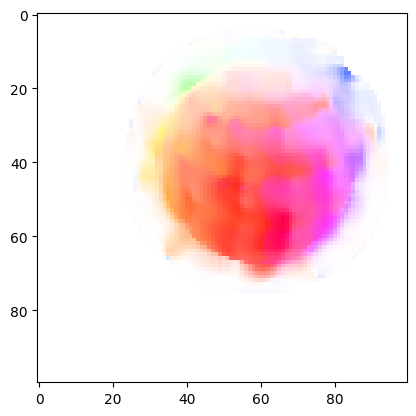

In [5]:
sphere = load_part1_images(
    path_list = ['./sphere/sphere_0.png', './sphere/sphere_1.png'],
    convert = img_to_gray_tensor
)
compute_flow(sphere, w_size=7, thresh=1E-10)

## Part 2. Tracking Keypoints on Moving Objects

In [6]:
class Keypoint:
    def __init__(self, x, y):
        self.x = [x]
        self.y = [y]
    def __repr__(self):
        return f"Keypoint x:{self.x} y:{self.y}"
    
def harris_corners(img, w_size, thresh):
    sigma = 5
    g = kornia.filters.get_gaussian_kernel2d((w_size, w_size), (sigma, sigma))
    dx, dy = spatial_derivatives(img)
    a = kornia.filters.filter2d(dx * dx, g, behaviour='conv')
    c = kornia.filters.filter2d(dx * dy, g, behaviour='conv')
    d = kornia.filters.filter2d(dy * dy, g, behaviour='conv')
    det = (a * d) - (c * c)
    trace = a + d

    # Harris corner response
    r = det - 0.04 * trace * trace
    r = r.squeeze()

    # set borders to zero -- don't want key points near edges
    r[:w_size,:] = 0
    r[-w_size:,:] = 0
    r[:,:w_size] = 0
    r[:,-w_size:] = 0

    # borrowed from my Assignment #1 code
    # only need to conduct non-max suppression for non-zero pixels
    nz = torch.where(r >= thresh, thresh, 0)
    nz_coords = torch.nonzero(nz).tolist()
    half_w = w_size // 2
    mask = torch.zeros((w_size, w_size))
    mask[half_w, half_w] = 1

    while nz_coords:
        i,j = nz_coords.pop()
        i_min, i_max = i - half_w, i + half_w + 1
        j_min, j_max = j - half_w, j + half_w + 1
        is_local_max = r[i,j] == torch.max(r[i_min:i_max,j_min:j_max])
        if is_local_max:
            # once we find local max, set rest of neighbourhood to zero
            r[i_min:i_max,j_min:j_max] = r[i_min:i_max,j_min:j_max] * mask
    return r >= thresh

def load_part2_images(path_list, convert):
    path_list.sort()
    imgs = []
    for filepath in path_list:
        tmp = plt.imread(filepath)
        imgs.append(convert(tmp))
    return imgs

def interp_flow(u):
    # interpolate flow so we can work with subpixels
    z = u.squeeze().numpy()
    h, w = z.shape
    x = np.arange(w)
    y = np.arange(h)
    # interp2d is deprecated and RectBivariateSpline is the suggested replacement from SciPy
    return RectBivariateSpline(y, x, z)

def validate_kp(kp, bounds, w_size):
    kp_x, kp_y = kp
    _, _, h, w = bounds    
    if (kp_x < w_size) or (kp_y < w_size):
        return False
    if (kp_x > w - w_size) or (kp_y > h - w_size):
        return False
    return True

In [7]:
hotel = load_part2_images(
    path_list = glob.glob('./hotel/hotel.seq*png'),
    convert = img_to_tensor
) 

corners = harris_corners(hotel[0], w_size=15, thresh=2e-16)
corners = torch.nonzero(corners).tolist()

### Select 20 corners to use as initial keypoints

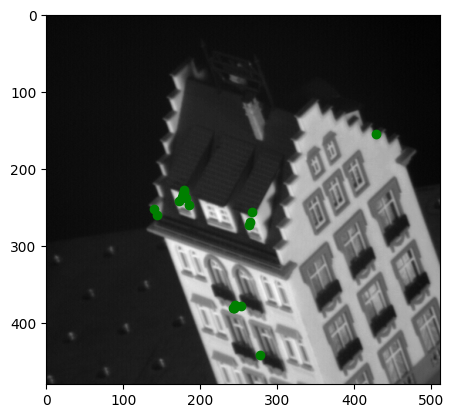

In [8]:
# select 20 keypoints
keypoints = []
for kp in sample(corners, 20):
    kp_y, kp_x = kp
    keypoints.append(Keypoint(kp_x, kp_y))

# plot
for kp in keypoints:
    plt.plot(kp.x[0], kp.y[0], marker="o", color="green")
plt.imshow(kornia.utils.tensor_to_image(hotel[0]), cmap="gray")
plt.show()

### Track keypoints through the frames

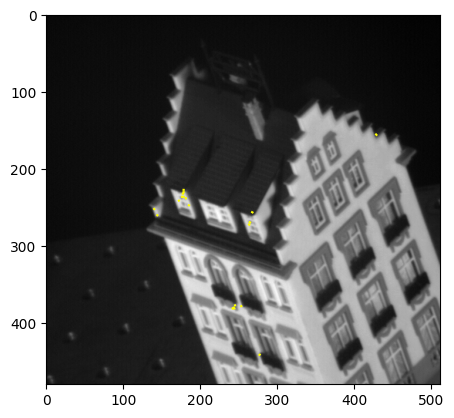

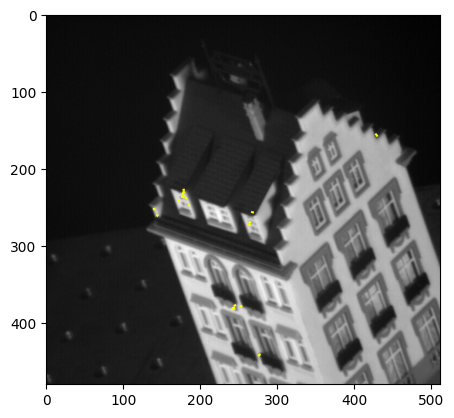

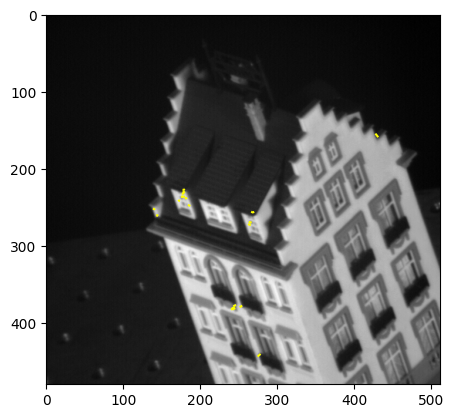

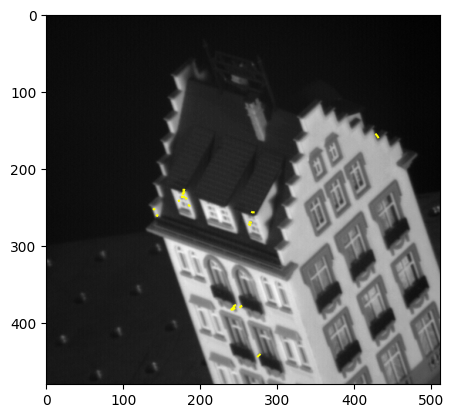

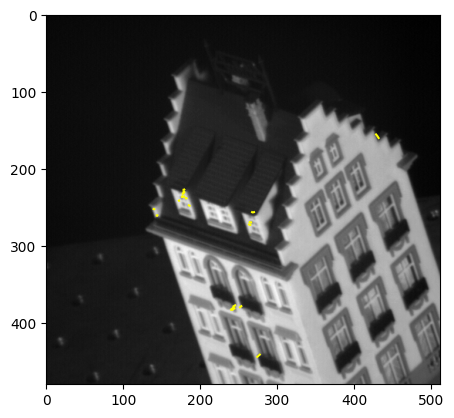

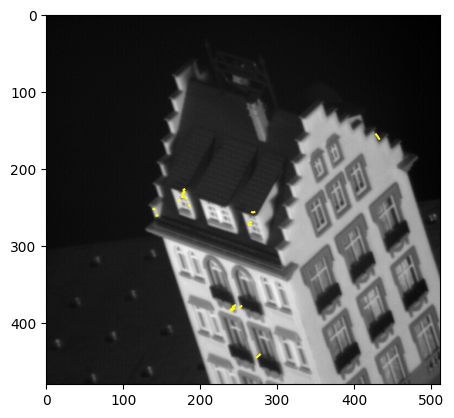

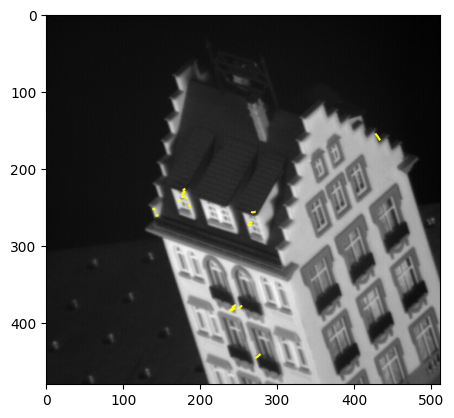

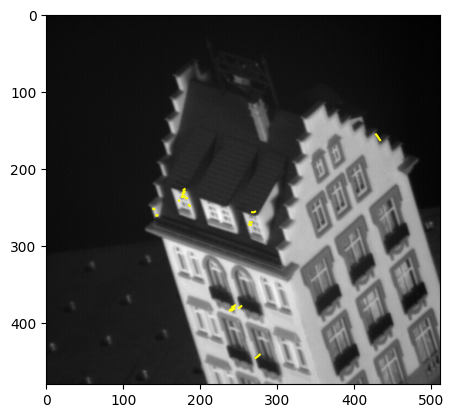

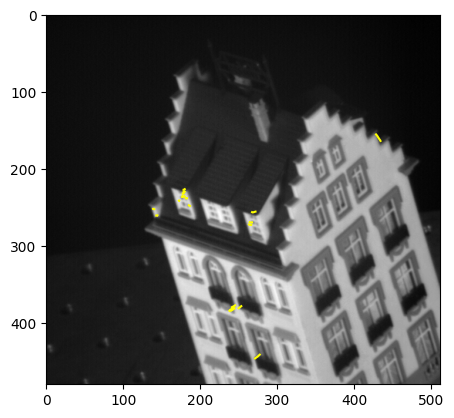

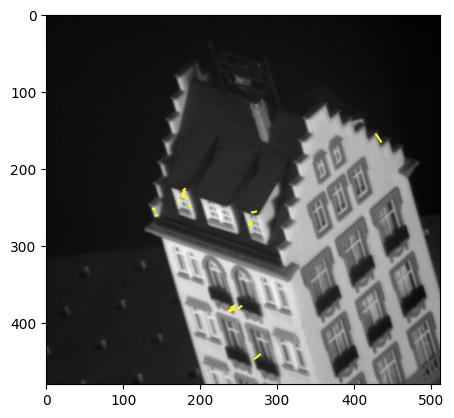

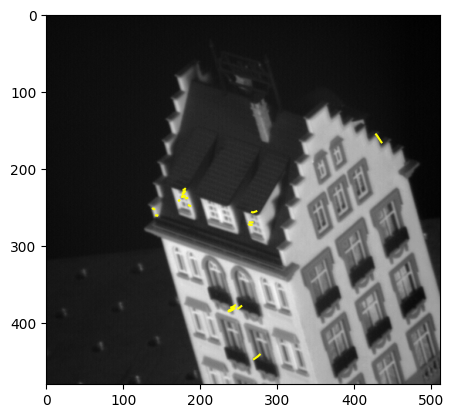

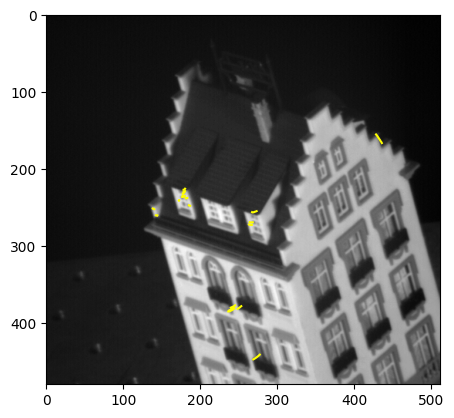

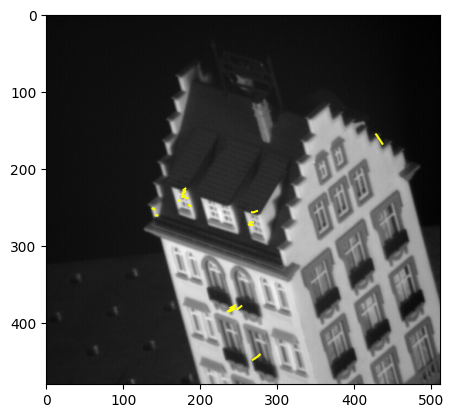

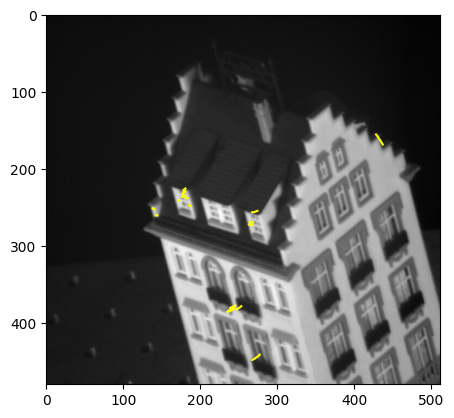

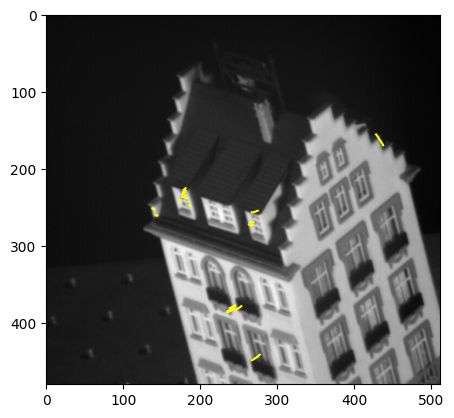

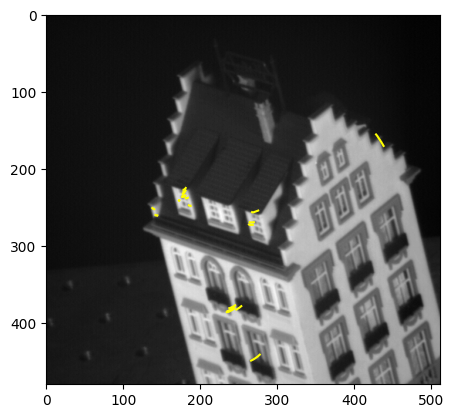

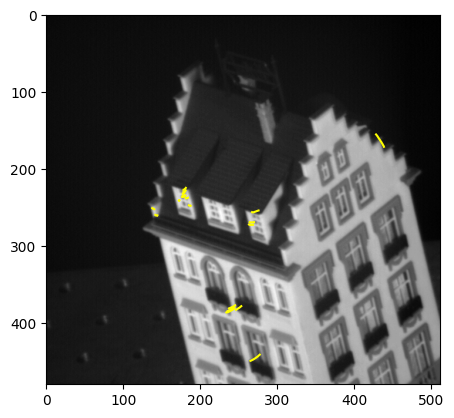

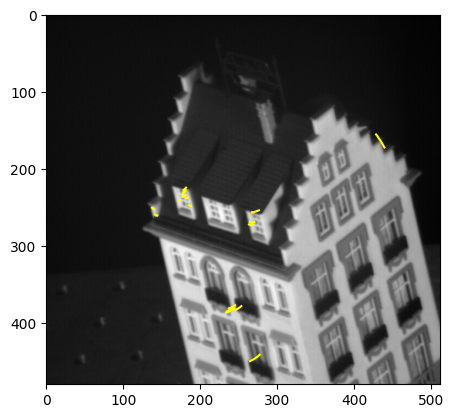

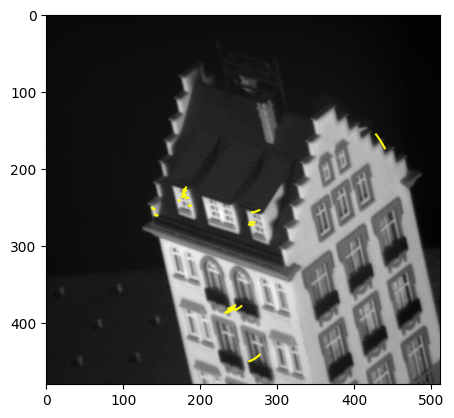

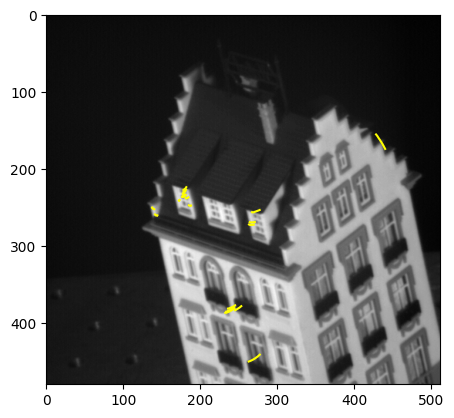

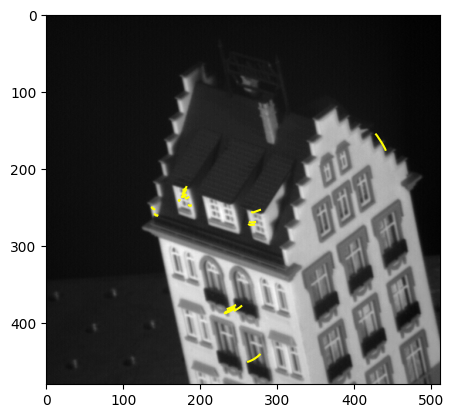

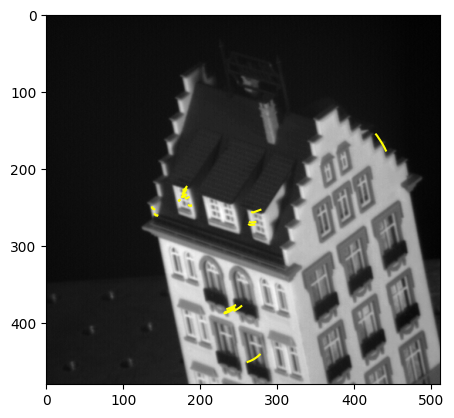

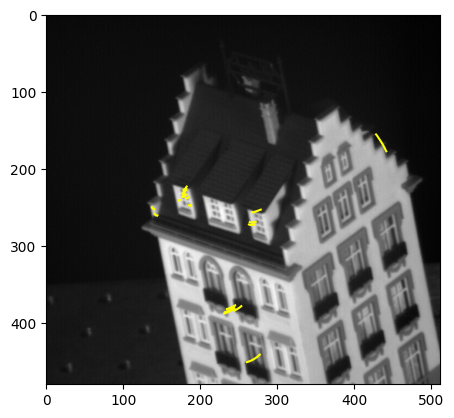

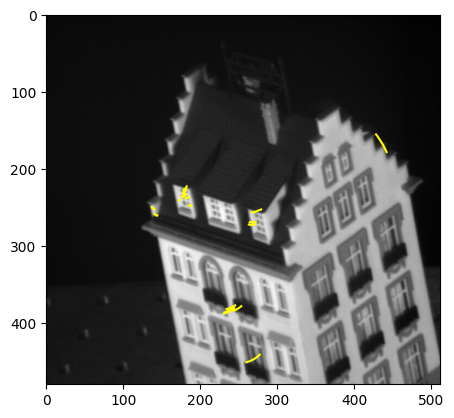

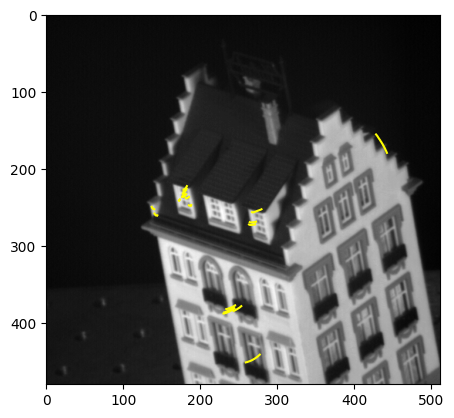

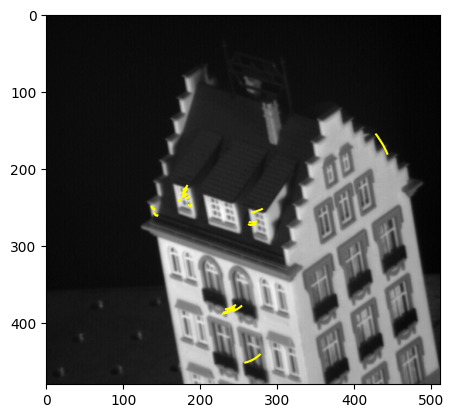

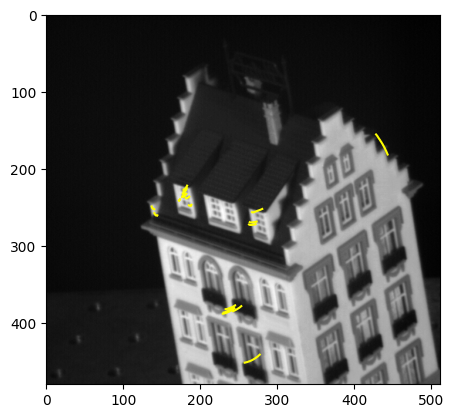

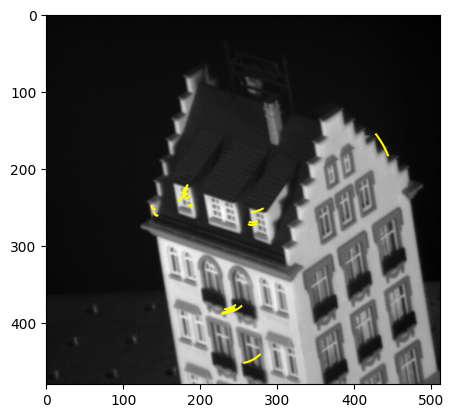

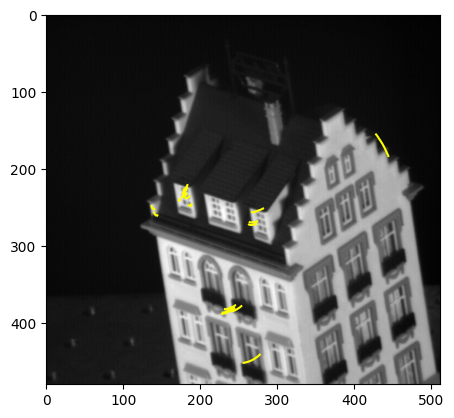

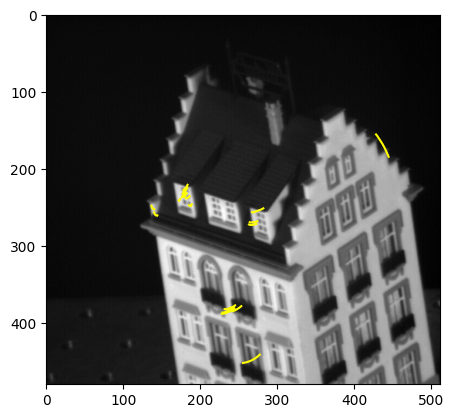

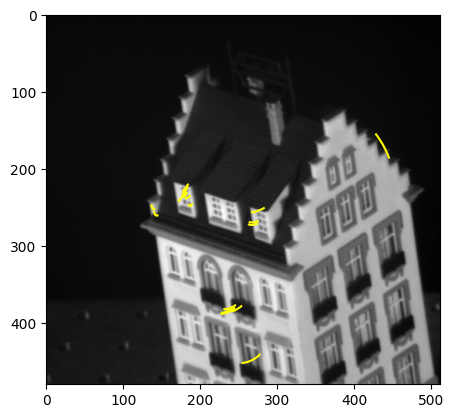

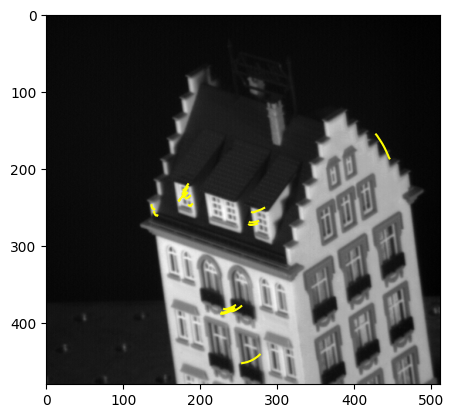

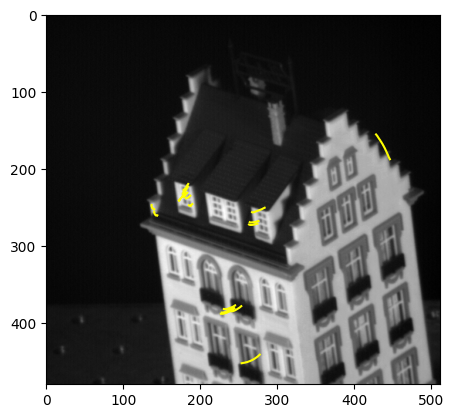

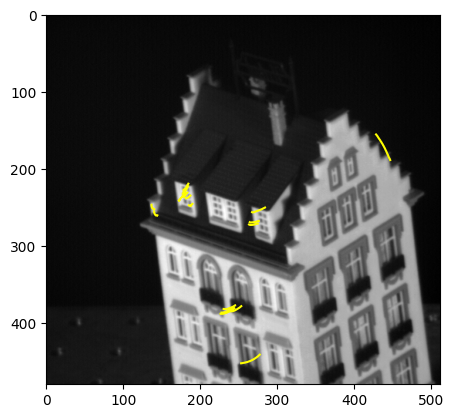

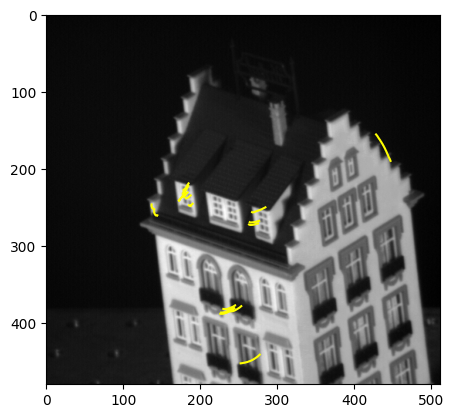

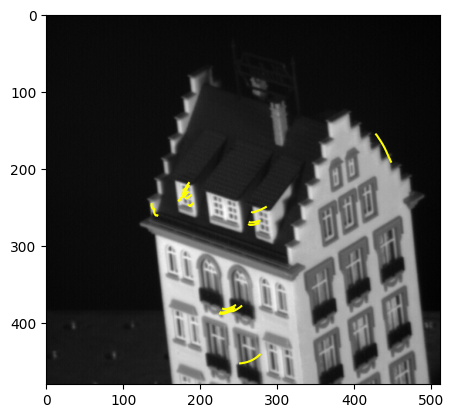

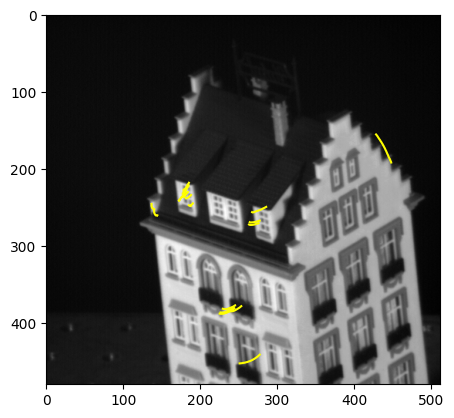

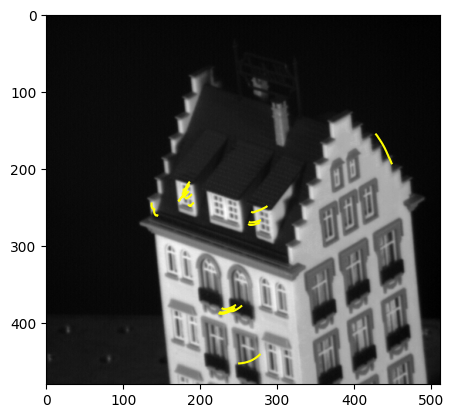

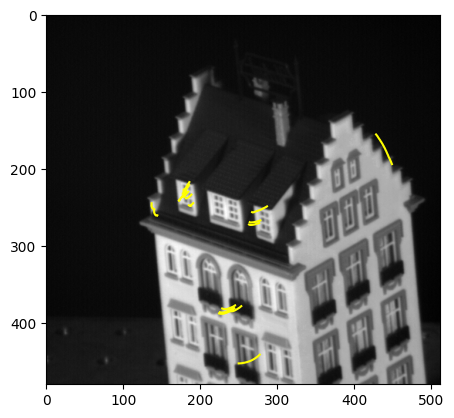

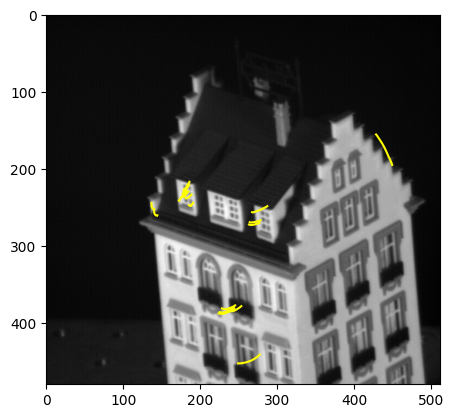

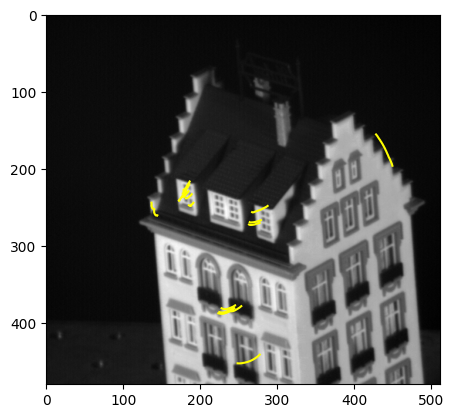

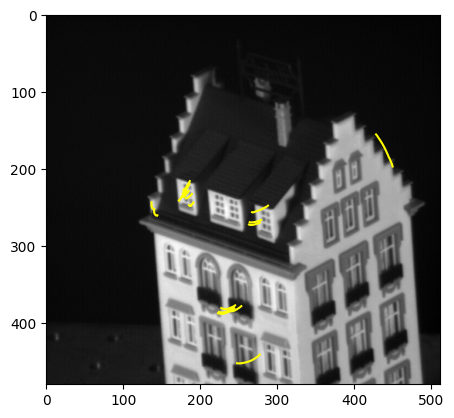

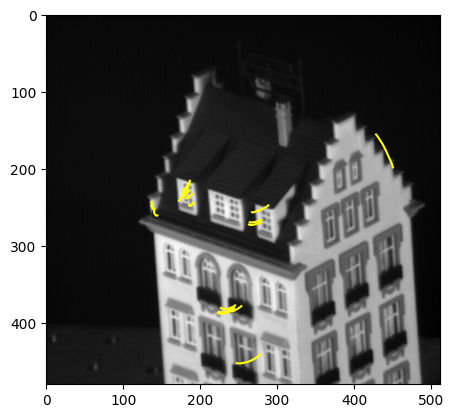

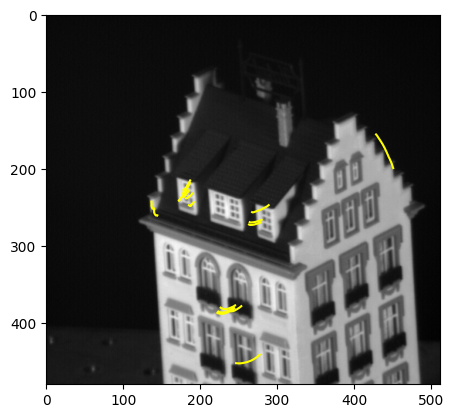

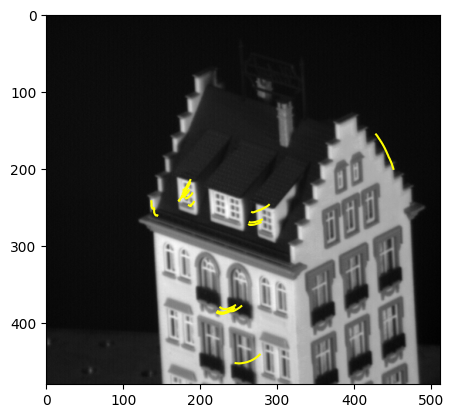

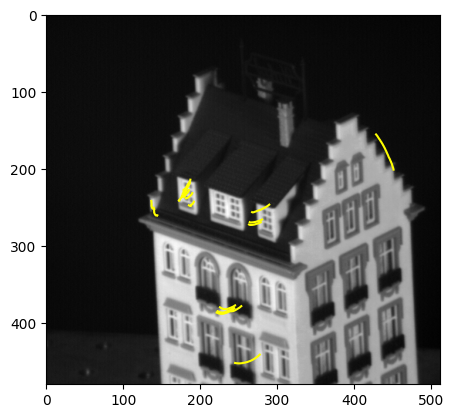

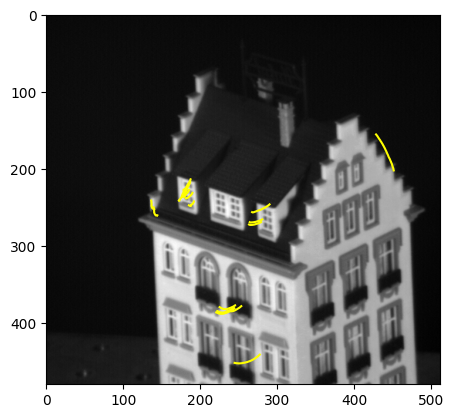

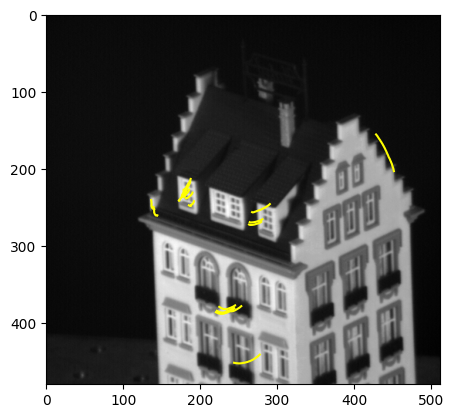

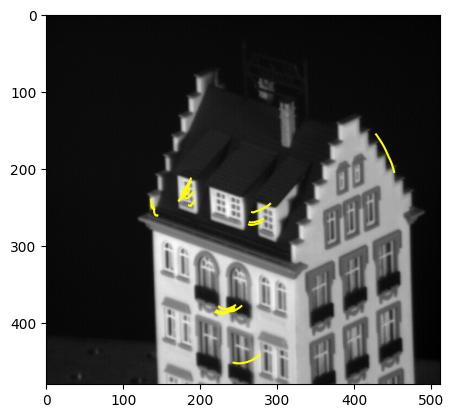

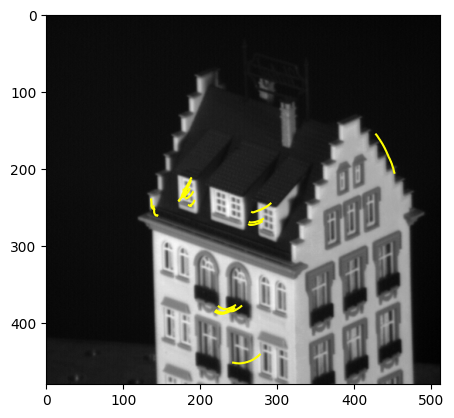

In [9]:
removed_keypoints = []
window = 15
for i in range(len(hotel) - 1):
    valid, u, v = optical_flow([hotel[i], hotel[i+1]], w_size=window, thresh=1E-10)
    u_func = interp_flow(u)
    v_func = interp_flow(v)
    new_keypoints = []
    for kp in keypoints:
        kp_x = kp.x[-1]
        kp_y = kp.y[-1]
        u_value = u_func(kp_y,kp_x).item()
        v_value = v_func(kp_y,kp_x).item()
        kp_x += u_value
        kp_y += v_value
        if validate_kp([kp_x, kp_y], hotel[i].shape, window):
            kp.x.append(kp_x)
            kp.y.append(kp_y)
            new_keypoints.append(kp)
            plt.plot(kp.x, kp.y, color="yellow")
        else:
            removed_keypoints.append(kp)
    keypoints = new_keypoints
    
    plt.imshow(kornia.utils.tensor_to_image(hotel[i]), cmap="gray")
    plt.show()

### Plot removed keypoints (if any)

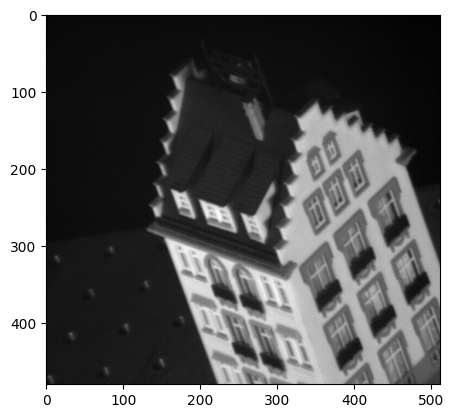

In [10]:
for kp in removed_keypoints:
    plt.plot(kp.x, kp.y, color="red")
plt.imshow(kornia.utils.tensor_to_image(hotel[0]), cmap="gray")
plt.show()